In [1]:
## IMPORT LIBRARIES
import os, glob, json, collections, time, copy
from natsort import natsorted

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.vision.all import *
from scipy.linalg import svd
from scipy.stats import ttest_1samp, t, sem

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [68]:
## DEFINE FUNCTIONS (MORE INFO INSIDE EACH FUNCTION)

def make_dataset(X_scaled_noise, y_main, comparison):
    if ("face" in comparison) or ("vehicle" in comparison):
        # if comparison is faces vs vehicle change the labels accordingly
        X = np.copy(X_scaled_noise)
        y = np.copy(y_main).astype("<U12")

        y[y == "male"] = "face"
        y[y == "female"] = "face"
        y[y == "car"] = "vehicle"
        y[y == "bike"] = "vehicle"
    elif len(comparison) == 4:
        # if comparison is all vs all import all the datapoints
        X = np.copy(X_scaled_noise)
        y = np.copy(y_main).astype("<U12")
    else:
        # if the comparison is with two classes import only relevant datapoints
        idxs = np.array([y_main == condition for condition in comparison])
        idx = np.array(
            [
                np.logical_or(idxs[0][col_id], idxs[1][col_id])
                for col_id in range(idxs.shape[1])
            ]
        )
        X = np.copy(X_scaled_noise[idx])
        y = np.copy(y_main[idx])
    return X, y


def classify(X, y):
    # classify
    skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    performance_step = np.zeros(skf.n_splits)
    reports = []
    i = 0
    for train_idx, test_idx in skf.split(X, y):
        #  print(f"## FOLD: {i+1} ##")
        # print("Indices of train-samples: %r" % train_idx.tolist())
        # print("Indices of test-samples: %r" % test_idx.tolist())
        # make test train sets
        X_train = X[train_idx]
        X_test = X[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]

        # fit your model on the transformed train-set
        clf = SVC(kernel="linear", random_state=42).fit(X_train, y_train)
        # predict (cross-validate to the transformed test-set;)
        y_hat = clf.predict(X_test)
        y_hat_training = clf.predict(X_train)
        performance_step[i] = clf.score(X_test, y_test)
        train_p = clf.score(X_train, y_train)

        # print(
        #     f'TRAINING BATCH: \t{list(y_train)} \nTRAINING PREDICTED: {list(y_hat_training)}'
        # print(f"TARGET: \t{list(y_test)} \nPREDICTED: \t{list(y_hat)}")
        # print(f"TRAINING ACC: {train_p}, TEST ACC: {round(performance_step[i],2)}\n")
        i += 1

    acc = np.average(performance_step)
    #  print(f"TOTAL ACCURACY: {round(acc, 2)}\n\n")
    return performance_step


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sem(a)
    h = se * t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h, se


def label_from_path(path):
    filename = os.path.splitext(os.path.basename(path))[0]
    if "b" in filename:
        label = "bike"
    elif "c" in filename:
        label = "car"
    elif "f" in filename:
        label = "female"
    elif "m" in filename:
        label = "male"
    return label

def plot_filters(t):
    
    # check if dimensionality is correct
    if len(t.shape) == 3:
        t.unsqueeze(1)

    # get the number of kernels
    num_kernels = t.shape[0]
    
    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels

    # set the figure size
    fig = plt.figure(figsize=(num_cols, num_rows))

    # looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)

        # for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis("off")
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    # plt.savefig('myimage.png', dpi=100)
    plt.tight_layout()
    plt.show()


def get_feat_vector_l1(path_img, model, preprocess):
    input_image = Image.open(path_img)

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        my_output = None

        def my_hook(module_, input_, output_):
            nonlocal my_output
            my_output = output_

        a_hook = model.features[0].register_forward_hook(my_hook)
        model(input_batch)
        a_hook.remove()
        return my_output


def get_feat_vector_l7(path_img, model, preprocess):
    input_image = Image.open(path_img)

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        my_output = None

        def my_hook(module_, input_, output_):
            nonlocal my_output
            my_output = output_

        a_hook = model.classifier.register_forward_hook(my_hook)
        model(input_batch)
        a_hook.remove()
        return my_output


In [7]:
## SOME IMPORTANT THINGS BEFORE LOADING THE NETWORK:

## LOAD IMAGENET LABELS TO ASSESS NETWORK PERFORMANCE
imagenet_labels_path = r"C:\Users\45027900\Desktop\project\imagenet_class_index.json"

with open(imagenet_labels_path, "r") as h:
    imagenet_labels = json.load(h)
    
# here we print first and last 5 labels, just to make sure everything looks fine
print('ImageNet labels (first and last 5):')
print(pd.DataFrame.from_dict(imagenet_labels, orient='index').head())
print(pd.DataFrame.from_dict(imagenet_labels, orient='index').tail())

## DEFINE DATASET OF IMAGES TO FEED TO THE NETWORK
img_dir = r"C:\Users\45027900\Desktop\model_old\data\original"
img_labels = pd.read_csv(os.path.join(img_dir, "labels", "labels.csv"), header=None)

total_imgs = natsorted(glob.glob(os.path.join(img_dir, "*.png")))
print(f'\nTotal number of images in the dataset: {str(len(total_imgs))}')

## DEFINE PREPROCESSING WE WANT TO APPLY TO EACH IMAGE
## (NORMALIZATION VALUES ARE MEAN AND SD OF THE IMAGENET DATASET)
preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## INIT DICTIONARY TO STORE RESULTS
data_dict = {
    os.path.splitext(os.path.basename(path))[0]: {
        "imgpath": path,
        "label": label_from_path(path),
        "predicted": str,
        "l1": Tensor(),
        "l7": Tensor(),
    }
    for path in total_imgs
}


ImageNet labels (first and last 5):
           0                  1
0  n01440764              tench
1  n01443537           goldfish
2  n01484850  great_white_shark
3  n01491361        tiger_shark
4  n01494475         hammerhead
             0                 1
995  n13044778         earthstar
996  n13052670  hen-of-the-woods
997  n13054560            bolete
998  n13133613               ear
999  n15075141     toilet_tissue

Total number of images in the dataset: 120


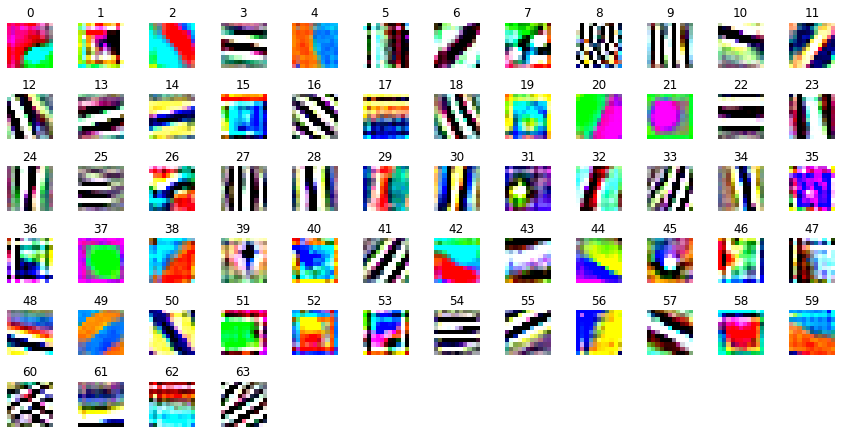

In [15]:
## INIT ALEXNET PLOT FIRST CONV LAYER WEIGHTS 
## (TO MAKE SURE THEY CAN DETECT EDGES/ORIENTATIONS)
net = alexnet(pretrained=True, progress=True)
plot_filters(net.features[0].weight.data)


STEP: feeding images to the network and extracting predicted label + layers outputs..
Plotting an example image..:


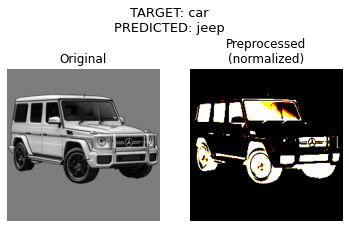

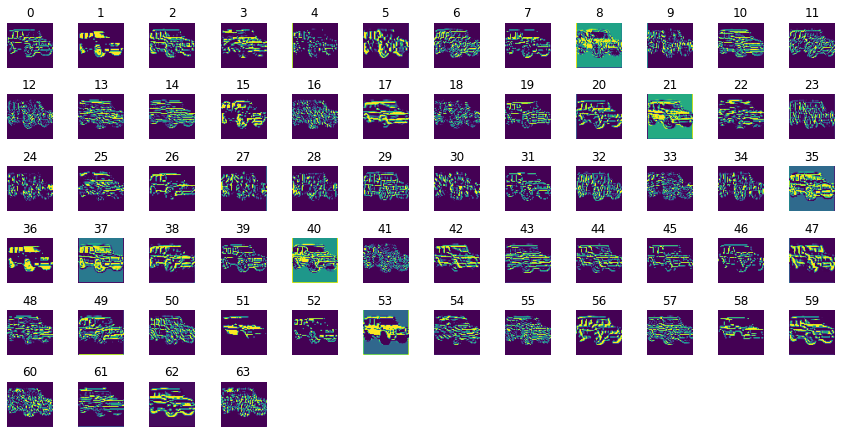

done!


In [21]:
## PASS EVERY IMAGE TO THE NETWORK AND EXTRACT 1ST AND LAST LAYER OUTPUT
## FOR THE FIRST IMAGE WE ALSO PLOT 1ST LAYER ACTIVATION (FILTERS), PREPROCESSED IMAGE AND PREDICTED VS TARGET LABEL
print(f"STEP: feeding images to the network and extracting predicted label + layers outputs..")
for item in data_dict.keys():
    ## GET AN IMAGE
    img_path = data_dict[item]["imgpath"]

    ## GET LAYERS 1 AND 7
    l1 = get_feat_vector_l1(img_path, net, preprocess)
    l7 = get_feat_vector_l7(img_path, net, preprocess)
    data_dict[item]["l1"] = l1.numpy()
    data_dict[item]["l7"] = l7.numpy()
    
    ## GET PREDICTED LABEL
    _, predicted = torch.max(l7.data, 1)
    data_dict[item]["predicted"] = imagenet_labels[str(int(predicted[0]))][1]
    
    ## PLOT TO SHOWCASE
    if item == 'c9':
        print('Plotting an example image..:')
        # PLOT ORIGINAL VS. PREPROCESSED IMAGE
        image = Image.open(img_path)
        image_preproc = Image.fromarray(preprocess(image).permute(1, 2, 0).numpy().astype('uint8'))
        
        fig = plt.figure()
        fig.suptitle(f'TARGET: {data_dict[item]["label"]}\nPREDICTED: {data_dict[item]["predicted"]}\n', fontsize=13)
        
        ax = fig.add_subplot(1, 2, 1)
        imgplot = plt.imshow(image)
        ax.set_title('Original')
        plt.axis('off')

        ax = fig.add_subplot(1, 2, 2)
        imgplot = plt.imshow(image_preproc)
        ax.set_title('Preprocessed\n(normalized)')
        plt.axis('off')

        # PLOT FIRST CONV LAYER
        l1_filters = l1.squeeze(0).unsqueeze(1)
        plot_filters(l1_filters.data)
print('done!')


In [276]:
## HERE WE WANT TO ORGANIZE ALL THE LAYER 1 OUTPUTS (ONE FOR EACH IMAGE IN THE DATASET) IN AN ARRAY FOR THE CLASSIFIER
## BUT THERE IS A PROBLEM: THE SVM CLASSIFIER EXPECTS AN ARRAY WITH OBSERVATIONS AS ROWS, AND FEATURES AS COLUMNS
## BUT THE LAYER OUTPUT SHAPE IS 64 * 55 * 55. THE EASY SOLUTION IS TO FLATTEN THIS TENSOR TO GET A VECTOR, BUT THIS WILL 
## BE A PROBLEM FOR THE CLASSIFIER (CURSE OF DIMENSIONALITY). A GOOD STRATEGY HERE IS TO DO SOME SORT OF DIMENSIONALITY 
## REDUCTION TO REDUCE THE NUMBER OF FEATURE TO SOMETHING MORE REASONABLE. HERE WE USE THE TRUNCATED SVD (AKA LSA).

## INIT SVD DIMENSIONALITY REDUCTION ESTIMATOR
svd = TruncatedSVD(n_components=100, random_state=42)

## GET THE TARGET LABELS
keys = list(data_dict.keys())
y_main = np.array([data_dict[key]["label"] for key in keys])

## GET ALL THE OUTPUTS, NORMALIZE, FIT THE ESTIMATOR AND TRANSFORM EACH OUTPUT IN A VECTOR WITH 100 FEATURES
X_main = np.array([data_dict[key]["l1"].squeeze(0).flatten() for key in keys])
X_main = StandardScaler(with_std=False).fit_transform(X_main)
print(f'Size of the dataset BEFORE dimensionality reduction: \t{X_main.shape}')
X_main = svd.fit_transform(X_main, y_main)
print(f'Size of dataset AFTER dimensionality reduction: \t{X_main.shape}')

## SHUFFLE DATASET (WE USE TUPLES TO MAKE SURE LABELS DON'T GET MEESED UP)
random.seed(42)
comp = list(zip(X_main, y_main))
random.shuffle(comp)
X_main, y_main = zip(*comp)

## TRANSFORM TUPLES BACK INTO ARRAYS
X_main = np.array(X_main)
y_main = np.array(y_main)



Size of the dataset BEFORE dimensionality reduction: 	(120, 193600)
Size of dataset AFTER dimensionality reduction: 	(120, 100)


Size of the noise array: (5, 120, 100)
Let's check if the noise looks normally distributed...


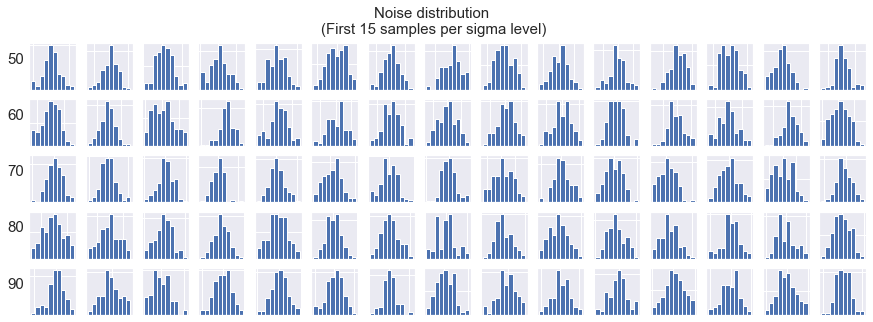

In [327]:
## HERE WE WANT TO ADD GAUSSIAN NOISE TO EACH FEATURE IN THE DATASET (MEAN = FEATURE_MEAN, SIGMA = 30:80)
## (BECAUSE OTHERWISE WE WOULD HAVE VERY HIGH, UNREALISTIC PERFORMANCE COMPARED TO THE SVM ON FMRI DATA)

noise_stds = list(range(
    50,
    100,
    10))

np.random.seed(42)
noise = np.zeros((len(noise_stds), X_main.shape[0], X_main.shape[1]))
for feature in range(X_main.shape[1]):
    for noise_id, noise_std in enumerate(noise_stds):
        noise[noise_id, :, feature] = np.random.normal(
            np.average(X_main[:, feature]), noise_std, len(X_main[:, feature])
        )

# noise = np.array([np.random.normal(np.average(X_main), noise_std, (X_main.shape[0], X_main.shape[1])) for noise_std in noise_stds])
print(f'Size of the noise array: {noise.shape}')

print("Let's check if the noise looks normally distributed...")
num_rows = len(noise_stds)
num_cols = 15

fig = plt.figure(figsize=(num_cols, num_rows))

# looping through all the kernels
position = 1
for noise_id, noise_sigma in enumerate(noise_stds):
    for sample in range(15):
        ax1 = fig.add_subplot(num_rows, num_cols, position)
        ax1.hist(noise[noise_id, sample])
        if sample == 0:
            ax1.set_ylabel(str(noise_sigma), rotation='horizontal', fontsize=15)
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        position += 1

plt.suptitle("Noise distribution \n(First 15 samples per sigma level)", fontsize=15)
plt.show()


In [328]:
## INITIALIZE THE DATAFRAME FOR STORING AND PLOTTING RESULTS
comparisons = [
    ("face", "vehicle"),
    ("female", "male"),
    ("bike", "car"),
    ("bike", "car", "female", "male"),
]

graph_df = pd.DataFrame(
    None, columns=("comparison", "noise", "avg", "std", "sem", "cimin", "cimax", "p", "t")
)
graph_df["comparison"] = [
    comparison for comparison in comparisons for i in range(len(noise_stds))
]
graph_df["noise"] = [noise for i in range(len(comparisons)) for noise in noise_stds]

print(graph_df)

                   comparison  noise  avg  std  sem cimin cimax    p    t
0             (face, vehicle)     50  NaN  NaN  NaN   NaN   NaN  NaN  NaN
1             (face, vehicle)     60  NaN  NaN  NaN   NaN   NaN  NaN  NaN
2             (face, vehicle)     70  NaN  NaN  NaN   NaN   NaN  NaN  NaN
3             (face, vehicle)     80  NaN  NaN  NaN   NaN   NaN  NaN  NaN
4             (face, vehicle)     90  NaN  NaN  NaN   NaN   NaN  NaN  NaN
5              (female, male)     50  NaN  NaN  NaN   NaN   NaN  NaN  NaN
6              (female, male)     60  NaN  NaN  NaN   NaN   NaN  NaN  NaN
7              (female, male)     70  NaN  NaN  NaN   NaN   NaN  NaN  NaN
8              (female, male)     80  NaN  NaN  NaN   NaN   NaN  NaN  NaN
9              (female, male)     90  NaN  NaN  NaN   NaN   NaN  NaN  NaN
10                (bike, car)     50  NaN  NaN  NaN   NaN   NaN  NaN  NaN
11                (bike, car)     60  NaN  NaN  NaN   NaN   NaN  NaN  NaN
12                (bike, car)     70  

In [329]:
## THIS IS THE MAIN LOOP FOR THE CLASSIFICATION

# FOR EACH NOISE SIGMA LEVEL
for noise_id, noise_std in enumerate(noise_stds):
    print(f'## NOISE: {noise_std}')
    # ADD NOISE TO THE ORIGINAL DATASET
    X = X_main + noise[noise_id]
    y = y_main.copy()

    # FOR EACH COMPARISON (E.G., FACE VS VEHICLE)
    for comparison in comparisons:
        
        # SELECT OBSERVATIONS BASED ON THE COMPARISON (E.G., ONLY BIKES AND CARS)
        X_comp, y_comp = make_dataset(X.copy(), y.copy(), comparison)
        
        # RUN THE CLASSIFICATION
        print(f'\t# COMPARISON: {comparison}')
        performance_list = []
        performance_list = classify(X_comp, y_comp)

        # RUN THE T-TEST AGAINST CHANCE LEVEL
        labels_n = len(comparison)

        graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 't'], graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'p'] = ttest_1samp(
            performance_list, popmean=1/labels_n, alternative='greater')
        
        graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'std'] = np.std(performance_list)

        
        graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'avg'], graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'cimin'], graph_df.loc[(
        (graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'cimax'], graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'sem'] = mean_confidence_interval(performance_list)

        # PRINT SUMMARY
        print(
            f"""\t\tt = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 't'].astype(float).values[0], 3)}, 
            \tp = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'p'].astype(float).values[0], 3)}, 
            \tavg = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'avg'].astype(float).values[0], 3)}, 
            \tsem = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['noise'] == noise_std)), 'sem'].astype(float).values[0], 3)}"""
            )


## NOISE: 50
	# COMPARISON: ('face', 'vehicle')
		t = 15.657, 
            	p = 0.0, 
            	avg = 0.883, 
            	sem = 0.024
	# COMPARISON: ('female', 'male')
		t = 0.545, 
            	p = 0.296, 
            	avg = 0.533, 
            	sem = 0.061
	# COMPARISON: ('bike', 'car')
		t = 1.61, 
            	p = 0.062, 
            	avg = 0.6, 
            	sem = 0.062
	# COMPARISON: ('bike', 'car', 'female', 'male')
		t = 8.865, 
            	p = 0.0, 
            	avg = 0.558, 
            	sem = 0.035
## NOISE: 60
	# COMPARISON: ('face', 'vehicle')
		t = 25.682, 
            	p = 0.0, 
            	avg = 0.95, 
            	sem = 0.018
	# COMPARISON: ('female', 'male')
		t = 0.0, 
            	p = 0.5, 
            	avg = 0.5, 
            	sem = 0.051
	# COMPARISON: ('bike', 'car')
		t = 3.901, 
            	p = 0.0, 
            	avg = 0.717, 
            	sem = 0.056
	# COMPARISON: ('bike', 'car', 'female', 'male')
		t = 6.902, 
            	p = 0.0, 
            	avg =

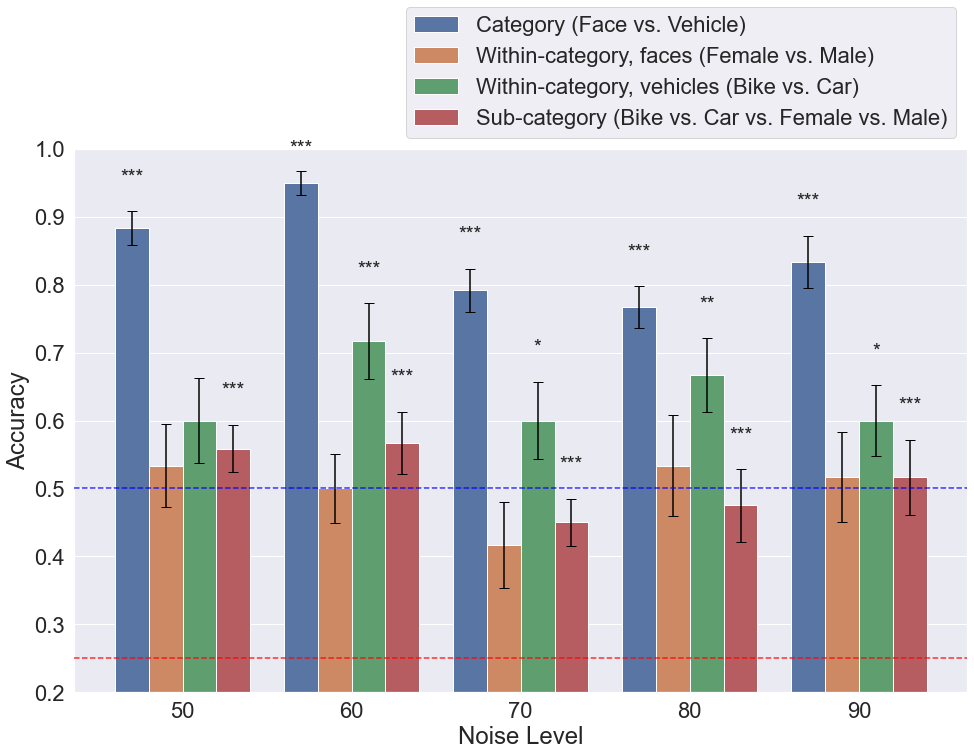

In [330]:
## PLOT 
sns.set(font_scale=2)

# SET PLOTTING ORDER
graph_df['order'] = 0

graph_df.loc[graph_df['comparison'] == ('face', 'vehicle'), 'order'] = 0
graph_df.loc[graph_df['comparison'] == ('female', 'male'), 'order'] = 1
graph_df.loc[graph_df['comparison'] == ('bike', 'car'), 'order'] = 2
graph_df.loc[graph_df['comparison'] == ('bike', 'car', 'female', 'male'), 'order'] = 3

graph_df.sort_values(
    ['noise', 'order'], axis=0, inplace=True, ignore_index=True)

# INITIALIZE FIGURE
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='noise', y='avg', hue='comparison', data=graph_df, ax=ax)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Noise Level')

# MAKE LEGEND
L = plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower right")
L.get_texts()[0].set_text('Category (Face vs. Vehicle)')
L.get_texts()[1].set_text('Within-category, faces (Female vs. Male)')
L.get_texts()[2].set_text('Within-category, vehicles (Bike vs. Car)')
L.get_texts()[3].set_text('Sub-category (Bike vs. Car vs. Female vs. Male)')

# MAKE ERROR BARS (SEM)
x_pos = np.array([[ax.get_xticks()[i] - 0.3, ax.get_xticks()[i] - 0.1, + ax.get_xticks()[i] + 0.1, ax.get_xticks()[i] + 0.3, ]
                  for i in range(len(ax.get_xticks()))]).flatten()
y_pos = graph_df['avg']
yerr = np.array(graph_df['sem'])
plt.errorbar(x=x_pos, y=y_pos, yerr=yerr, fmt='none',
             c='black', capsize=5)

# DEFINE PLOT RANGE AND PLOT CHANCE LINES (25%, 50%)
plt.ylim((0.2, 1))
plt.axhline(0.5, alpha=0.8, color='blue', ls='--', zorder=4)
plt.axhline(0.25, alpha=0.8, color='red', ls='--', zorder=4)

# DRAW SIGNIFICANCE ANNOTATIONS
for i, p in enumerate(graph_df['p']):
    if p < 0.001:
        displaystring = r'***'
    elif p < 0.01:
        displaystring = r'**'
    elif p < 0.05:
        displaystring = r'*'
    else:
        displaystring = r''
    height = graph_df['sem'][i] + graph_df['avg'][i] + 0.05
    if height > 1:
        height = 1
    plt.text(x_pos[
        i], height, displaystring, ha='center', va='center', size=20)
    
plt.show()